### <left><b><font size=4>Section 3 – Unsupervised Learning – Clustering<b><left>

In [6]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import time
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

In [7]:
if not os.path.isfile("ssh_attacks_cleaned.parquet"):
    raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks_cleaned.parquet")

<div style="text-align: justify">Cluster the attacks according to their characteristics. Choose at least 2 Clustering Algorithms, and for each of them solve the following points.</div>

In [8]:
if not (os.path.isfile("df_features_bow.parquet") and os.path.isfile("df_features_tfidf.parquet")):
    raise Exception("You should run the section 1 before")
df_features_bow = pd.read_parquet("df_features_bow.parquet")
df_features_tfidf = pd.read_parquet("df_features_tfidf.parquet")
df_features_tfidf

,enable,system,shell,sh,cat,proc,mounts,bin,busybox,cd,...,nohup,tsm,150,up,txt,16,null,8m,20m,x17
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164691,...,0.0,0.000000,0.000000,0.000000,0.160661,0.000000,0.16466,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164691,...,0.0,0.000000,0.000000,0.000000,0.160661,0.000000,0.16466,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164691,...,0.0,0.000000,0.000000,0.000000,0.160661,0.000000,0.16466,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164691,...,0.0,0.000000,0.000000,0.000000,0.160661,0.000000,0.16466,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164691,...,0.0,0.000000,0.000000,0.000000,0.160661,0.000000,0.16466,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.248516,0.166358,0.165693,0.000000,0.082902,0.00000,0.0,0.0,0.0
233031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.248516,0.166358,0.165693,0.000000,0.082902,0.00000,0.0,0.0,0.0
233032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.248516,0.166358,0.165693,0.000000,0.082902,0.00000,0.0,0.0,0.0
233033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.248516,0.166358,0.165693,0.000000,0.082902,0.00000,0.0,0.0,0.0


In [9]:
df_clustering = pd.concat([df[["full_session", "Set_Fingerprint"]], df_features_tfidf], axis=1)
df_clustering = df_clustering.sample(frac=0.50).reset_index()
df_clustering

,index,full_session,Set_Fingerprint,enable,system,shell,sh,cat,proc,mounts,...,nohup,tsm,150,up,txt,16,null,8m,20m,x17
0,36671,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Execution, Persistence]",0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
1,217616,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
2,207288,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Execution, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
3,159423,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Harmless, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
4,84066,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Execution, Persistence]",0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116513,162308,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
116514,72259,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Execution, Persistence]",0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
116515,148059,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
116516,44497,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[Discovery, Persistence]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000


In [10]:
df_exploded = df_clustering.explode("Set_Fingerprint").reset_index()
df_exploded = df_exploded.drop(columns=['index'])

# We should use the stardardized data (X and y features)
labels = df_exploded["Set_Fingerprint"]
result_df_exploded = df_exploded.filter(df_features_tfidf.columns)
result_df_exploded

,enable,system,shell,sh,cat,proc,mounts,bin,busybox,cd,...,nohup,tsm,150,up,txt,16,null,8m,20m,x17
0,0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,0.101744,0.050785,0.0,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
1,0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,0.101744,0.050785,0.0,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
2,0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,0.101744,0.050785,0.0,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
278817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.248516,0.166358,0.165693,0.0,0.082902,0.0,0.000000,0.000000,0.000000
278818,0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,0.101744,0.050785,0.0,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507
278819,0.101749,0.050763,0.050873,0.050873,0.050873,0.050868,0.050875,0.101744,0.050785,0.0,...,0.101735,0.197431,0.056641,0.056414,0.0,0.056452,0.0,0.050785,0.356437,0.050507


<div style="text-align: justify"> Two clustering algorithms will be implemented to our dataset, the chosen were MiniBatchK-Means and Gaussian Mixture Model (GMM). <br>
First of all we have to select the features to be evaluate, <b>'Pricipal Component Analysis (PCA)'</b> was used to reduce the dimensionality of the data.</div>


##### Dimensionality Reduction by applying 'PCA'

In [11]:
# Reduce dimensionality using PCA
pca = PCA(n_components=10)        
pca_result_tfidf = pca.fit_transform(result_df_exploded)

#### K-Means

In [12]:
# k-Means with n_clusters = 3
# cl_labels3 = kmeans.fit_predict(features_exploted) # Get clusters ID
kmeans = KMeans(n_clusters=3)
cl_labels3 = kmeans.fit(pca_result_tfidf) # Using the features selected

# print the clustered labels
print("The clustered labels are:\n", kmeans.labels_)

# print the centroid of each feature for each cluster
print("The centroids are:\n", kmeans.cluster_centers_)

/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The clustered labels are:
 [1 1 1 ... 1 1 1]
The centroids are:
 [[ 5.12920373e-01 -8.20322115e-02 -3.22043601e-03 -2.14994258e-03
  -9.49056011e-04  4.60518130e-04 -1.55113597e-04 -3.65315286e-04
   7.25625996e-05  2.60539768e-04]
 [-4.62513042e-01 -8.21159221e-02  5.75520274e-03  1.62129439e-03
   4.17592332e-04 -1.73322463e-03 -2.60848388e-04 -1.19082497e-04
   3.38355766e-04 -1.92678798e-04]
 [-1.32423544e-02  1.17015664e+00 -2.12536092e-02  2.43041776e-03
   3.30363994e-03  9.85080830e-03  3.00269220e-03  3.36565686e-03
  -3.02352783e-03 -3.22942980e-04]]


In [13]:
# Unsupervised metric  (it takes approx 2500 sec o 3000 sec)
silhouette  = silhouette_score(pca_result_tfidf, kmeans.labels_)

# Supervised metrics
ri = rand_score(np.ravel(labels), kmeans.labels_)
ari = adjusted_rand_score(np.ravel(labels), kmeans.labels_)

In [14]:
print('k-Means with 3 clusters')
(unique, counts)=np.unique(kmeans.labels_, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

k-Means with 3 clusters
Size of each cluster:  [123789 136757  18275]
k_means clustering error: 4825.75
Silhouette: 0.95
RI: 0.57
ARI: 0.1


What are these parameters? 
- **Silhouette**: is a score that measures how similar is an object to its own cluster, compared to other clusters.
              The range of values that the Silhouette can assume is from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, so a good clustering structure.


- **RI(Rand Index)**:  is a measure of similarity among two clusterings. The range of values that Rand Index can assume is from 0 to 1,                     where a value of 1 indicates perfect similarity between two clusterings and a value of 0 indicates no similarity.


- **ARI(Adjusted Rand Index)**: it'a a way to "correct" the RI, a sort of normalization of it.
                                ARI ranges from -1 to 1, where a value close to 1 indicates strong agreement between two clusterings, a value close to 0 indicates random clustering, and negative values indicate disagreement.



#### Gaussian mixture model (GMM)

In [15]:
gmm = GaussianMixture(n_components=3)
gmm.fit(pca_result_tfidf)           # Get clusters ID

GaussianMixture(n_components=3)

In [16]:
# print the clustered labels
gmm_labels = gmm.predict(pca_result_tfidf)
print('The clustered labels are:\n', gmm_labels)

The clustered labels are:
 [0 0 0 ... 0 0 0]


In [17]:
# Unsupervised metric
silhouette  = silhouette_score(pca_result_tfidf, gmm_labels)
log_l = gmm.score(pca_result_tfidf)

# Supervised metrics
ri = rand_score(np.ravel(labels), gmm_labels)
ari = adjusted_rand_score(np.ravel(labels), gmm_labels)

In [18]:
# report effective size
print("Effetive size of each cluster: ", gmm.weights_)
# report usupervised and supervised metric
print(f'GMM total log-likelihood score: {round(log_l, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

Effetive size of each cluster:  [0.47632711 0.4366278  0.08704509]
GMM total log-likelihood score: 51.78
Silhouette: 0.93
RI: 0.57
ARI: 0.1


**3.1. Determine the number of clusters: This can be done using methods like the elbow method or
silhouette analysis. Explain your reasoning.**

<div style="text-align: justify"> The clustering error is strongly dependent form the number of cluster. 
The best situation, with the lowest error possible, is obiuously when we have the same number of clusters of the datapoins. Actually in this situation we're not even performing clustering, but the clustering error will be zero.<br>
<br>
Now we want to find the number of clusters that gives us the best results, so with the lowest clustering error. 
We'll follow 2 approches for each clustering algorithm applied, elbow method and validation error. </div>

#### K-Means Algorithm

In [19]:
# Step 1: Elbow Method  (260 sec)
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    kmeans_new = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans_new.fit_predict(pca_result_tfidf)
      
   # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rick_ubuntu/Scrivania/Untitled Folder/lib/python3.11/site-packages/sklearn/clus

**Elbow Method**

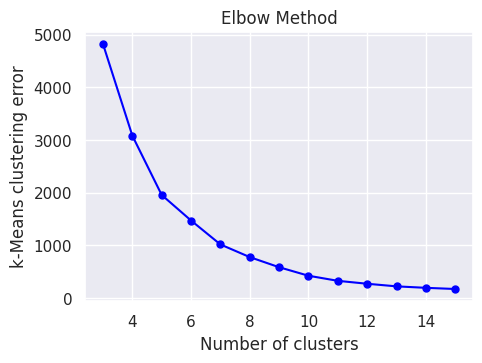

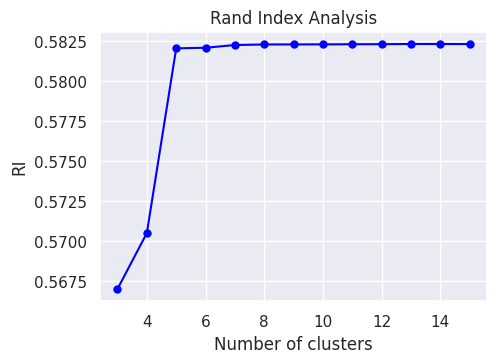

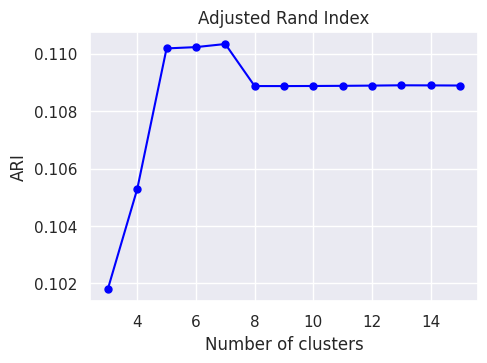

In [20]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

# Plot RI
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

#### Gaussian Mixture Model Algorithm (GMM)

In [21]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

for n_clusters in range(3, 16):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(pca_result_tfidf)
    
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    log_l_list.append(gmm.score(pca_result_tfidf))
    n_cluster_list.append(n_clusters)

**Elbow Method**

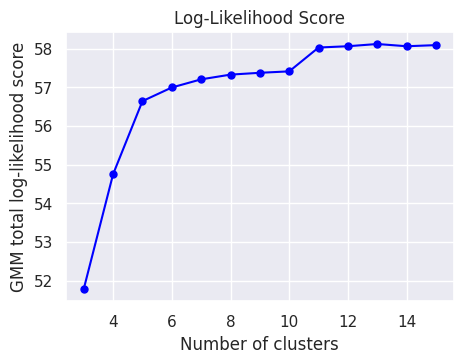

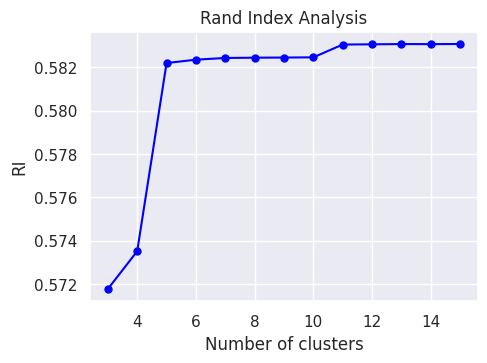

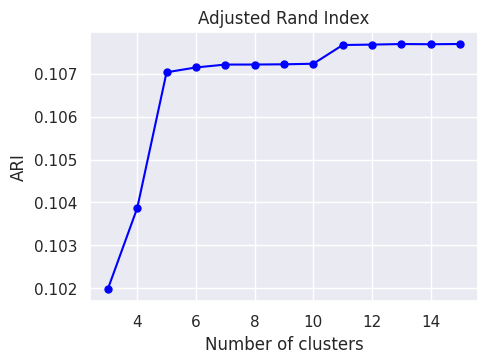

In [22]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')
plt.show()

# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.title('Adjusted Rand Index')
plt.ylabel('ARI')
plt.show()

**3.2. Tune other hyper-parameters, if any.**

##### Tunning the hyper-parameter of K-Means

In [23]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    # Selecting the number of optimal clusters = 9
    # 'k-means++': is an initialization that tends to converge faster than 'random'
    # Random State: It ensures that the initialization of centroids is reproducible (to obtaine same results in ech run)
    # n_init: determines the number of times the KMeans algorithm will be run with different centroid seeds.
    kmeans_tunning = KMeans(n_clusters = n_clusters, init ='k-means++', random_state = 42, n_init = 15)
    labels_tunning = kmeans_tunning.fit_predict(pca_result_tfidf)   # Using the features selected
    
    # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), labels_tunning))
    ari_list.append(adjusted_rand_score(np.ravel(labels), labels_tunning))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_tunning.inertia_)
    n_cluster_list.append(n_clusters)

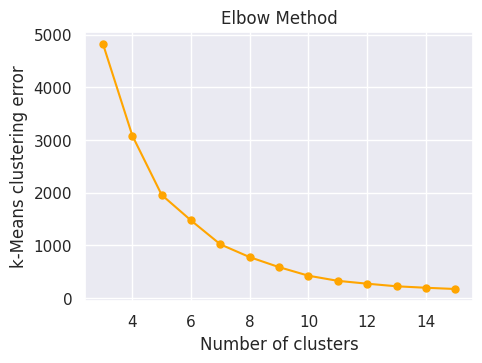

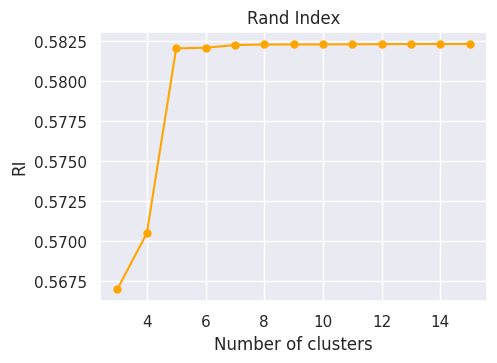

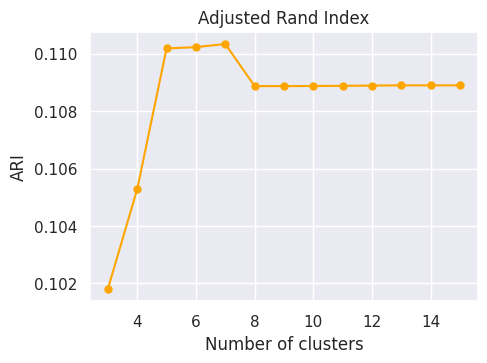

In [24]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set_theme(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

# Plot RI
# Set up Seaborn style
sns.set_theme(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list[:13], marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index')
plt.show()

# Plot ARI
# Set up Seaborn style
sns.set_theme(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

##### Tunning the hyper-parameters of GMM 

In [25]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

for n_clusters in range(3, 16):
    # The number of components was set in 16, the optimal number of cluster found was 9
    # covariance_type='full': Each component has its own general covariance matrix.
    # random_state: It ensures that if you run the GMM algorithm multiple times, 
    #               you will get the same initial conditions.
    # init_params='kmeans': controls the initialization method for the algorithm
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params='kmeans')
    cl_labels = gmm.fit_predict(pca_result_tfidf)
    
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    log_l_list.append(gmm.score(pca_result_tfidf))
    n_cluster_list.append(n_clusters)

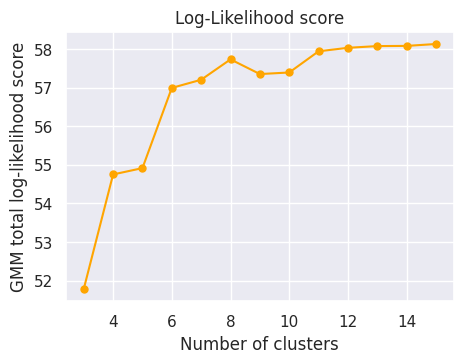

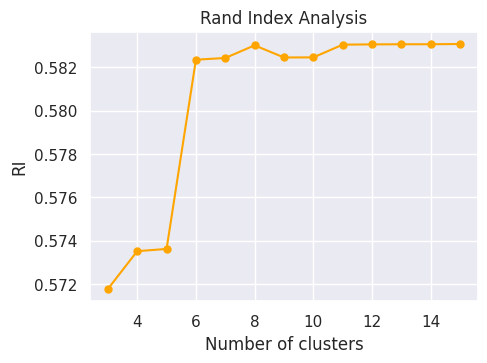

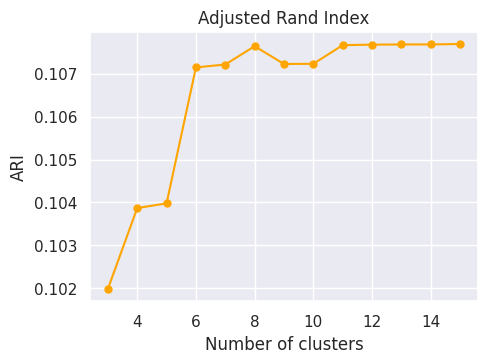

In [26]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood score')
plt.show()

# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.title('Adjusted Rand Index')
plt.ylabel('ARI')
plt.show()

**3.3. Visualize the clusters through t-SNE visualization.**

Let's apply the k-mean with the best hyper-parameters found:

In [28]:
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42, n_init=15)
cl_labels3 = kmeans.fit_predict(pca_result_tfidf) # Using the features selected

# print the clustered labels
print('The clustered labels are:\n', kmeans.labels_)
print()

# print the centroid of each feature for each cluster
print('The centroids are:\n', kmeans.cluster_centers_)
print()

The clustered labels are:
 [1 1 1 ... 1 1 1]

The centroids are:
 [[ 5.13103842e-01 -8.34177146e-02 -3.23871237e-03 -2.29748861e-03
  -3.31429547e-03  1.48525410e-04  1.96142374e-03  1.56052370e-03
  -2.30167780e-04  5.06097033e-04]
 [-4.76054161e-01 -8.98852329e-02 -1.39041962e-02 -1.73936752e-02
   3.00628076e-03 -2.56407757e-03  2.96803524e-04  4.08645431e-04
  -2.24336349e-04 -8.17185596e-05]
 [-1.34989735e-02  1.19195950e+00 -3.10016609e-02  3.83813789e-03
  -1.49722734e-02 -5.13464161e-03 -1.37694821e-03 -5.68150969e-04
   8.96395735e-04 -6.75388164e-04]
 [-7.97246930e-02  3.67496699e-01  8.56078978e-01 -3.40269183e-01
  -3.52582587e-02 -1.10608465e-01 -4.64383065e-02 -5.48870015e-02
  -3.29494149e-02 -6.19525255e-03]
 [-4.05069494e-01 -7.25316383e-02  1.30269805e-01  2.37379677e-01
  -9.17974000e-02  7.70675364e-02 -1.77156232e-02 -2.29183782e-02
   3.15654951e-03  6.84862545e-03]
 [-1.57352351e-01  1.38070940e-02  1.25070743e-01  3.74468247e-01
   1.86023946e-01 -2.33288127e-01

The goal of t-SNE is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane.

In [29]:
labels_df = pd.DataFrame(pca_result_tfidf)
labels_df['cluster'] = cl_labels3

X = labels_df.iloc[:,:-1]
print(X)
tsne = TSNE(n_components=2).fit_transform(X)

df_tsne = pd.DataFrame(tsne)
df_tsne["cluster"] = cl_labels3
df_tsne.columns = ["x1", "x2", "cluster"]
df_tsne

               0         1         2         3         4         5         6  \
0      -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   
1      -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   
2      -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   
3       0.513371 -0.083761 -0.003313 -0.002388 -0.003635 -0.000023  0.002076   
4       0.513371 -0.083761 -0.003313 -0.002388 -0.003635 -0.000023  0.002076   
...          ...       ...       ...       ...       ...       ...       ...   
278816  0.513371 -0.083761 -0.003313 -0.002388 -0.003635 -0.000023  0.002076   
278817  0.513371 -0.083761 -0.003313 -0.002388 -0.003635 -0.000023  0.002076   
278818 -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   
278819 -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   
278820 -0.476031 -0.089894 -0.013920 -0.017418  0.003022 -0.002608  0.000311   

               7         8         9  


,x1,x2,cluster
0,-5.365465,-234.551849,1
1,0.639483,-244.490082,1
2,0.907111,-244.542648,1
3,-133.254562,158.762253,0
4,-106.918846,189.924149,0
...,...,...,...
278816,-105.109253,199.041550,0
278817,-106.409790,195.908386,0
278818,-7.530916,-237.699173,1
278819,-12.077422,-239.106979,1


(-180.0, 250.0)

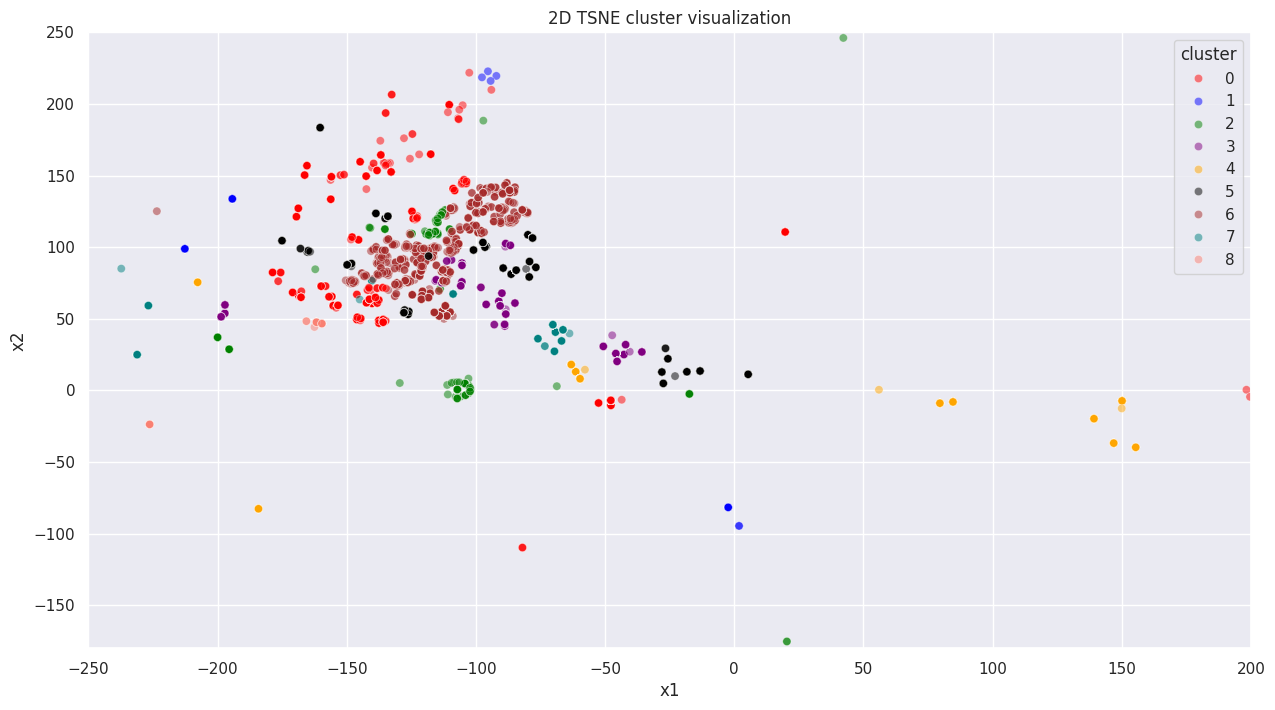

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "black", "brown", "teal", "salmon"]

sns.scatterplot(data=df_tsne, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full", alpha=0.5)
ax.set_title('2D TSNE cluster visualization')

ax.set_xlim([-250, 200])  
ax.set_ylim([-180, 250])  

In [37]:
full_sessions_exploted = df_clustering[["index","full_session", "Set_Fingerprint"]].explode("Set_Fingerprint")
full_sessions_exploted = full_sessions_exploted.rename(columns={'full_session': 'full_session_complete'})

full_sessions_exploted = full_sessions_exploted.drop(columns = ["index"])
full_sessions_exploted_array = full_sessions_exploted["full_session_complete"].to_numpy()
full_sessions_exploted_array

array([array(['cat', 'proc', 'cpuinfo', 'grep', 'name', 'wc', 'l', 'rm', 'rf',
              'var', 'tmp', '.var03522123', 'cat', 'var', 'tmp', '.var03522123',
              'head', 'n', '1', 'cat', 'proc', 'cpuinfo', 'grep', 'name', 'head',
              'n', '1', 'awk', 'print', '$4', '$5', '$6', '$7', '$8', '$9',
              'free', 'm', 'grep', 'Mem', 'awk', 'print', '$2', '$3', '$4', '$5',
              '$6', '$7', 'ls', 'lh', 'which', 'ls', 'which', 'ls', 'crontab',
              'l', 'w', 'uname', 'm', 'cat', 'proc', 'cpuinfo', 'grep', 'model',
              'grep', 'name', 'wc', 'l', 'top', 'uname', 'uname', 'a', 'lscpu',
              'grep', 'Model', 'rm', 'rf', 'var', 'tmp', 'dota*', 'cat', 'var',
              'tmp', '.systemcache436621', 'cat', 'var', 'tmp',
              '.systemcache436621', 'sleep', '15s', '&&', 'cd', 'var', 'tmp',
              '#!', 'bin', 'bash', 'cd', 'tmp\t', 'rm', 'rf', '.ssh', 'rm', 'rf',
              '.mountfs', 'rm', 'rf', '.X13', 'unix', 'r

In [51]:
df_afterClustering = pd.DataFrame()
df_afterClustering = df_exploded[["full_session","Set_Fingerprint"]].copy()
df_afterClustering["full_session_complete"] = full_sessions_exploted_array
df_afterClustering = df_afterClustering.copy()
df_afterClustering["cluster"] = cl_labels3

df_afterClustering = df_afterClustering[["full_session_complete", "full_session", "Set_Fingerprint", "cluster"]]

df_afterClustering

,full_session_complete,full_session,Set_Fingerprint,cluster
0,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Discovery,1
1,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Execution,1
2,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Persistence,1
3,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Discovery,0
4,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Persistence,0
...,...,...,...,...
278816,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Discovery,0
278817,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Persistence,0
278818,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Discovery,1
278819,"[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...","[cat, proc, cpuinfo, grep, name, wc, l, rm, rf...",Execution,1


**3.4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the most
representative.**

##### Most Frequent Words for the K-Means Cluster Algorithm

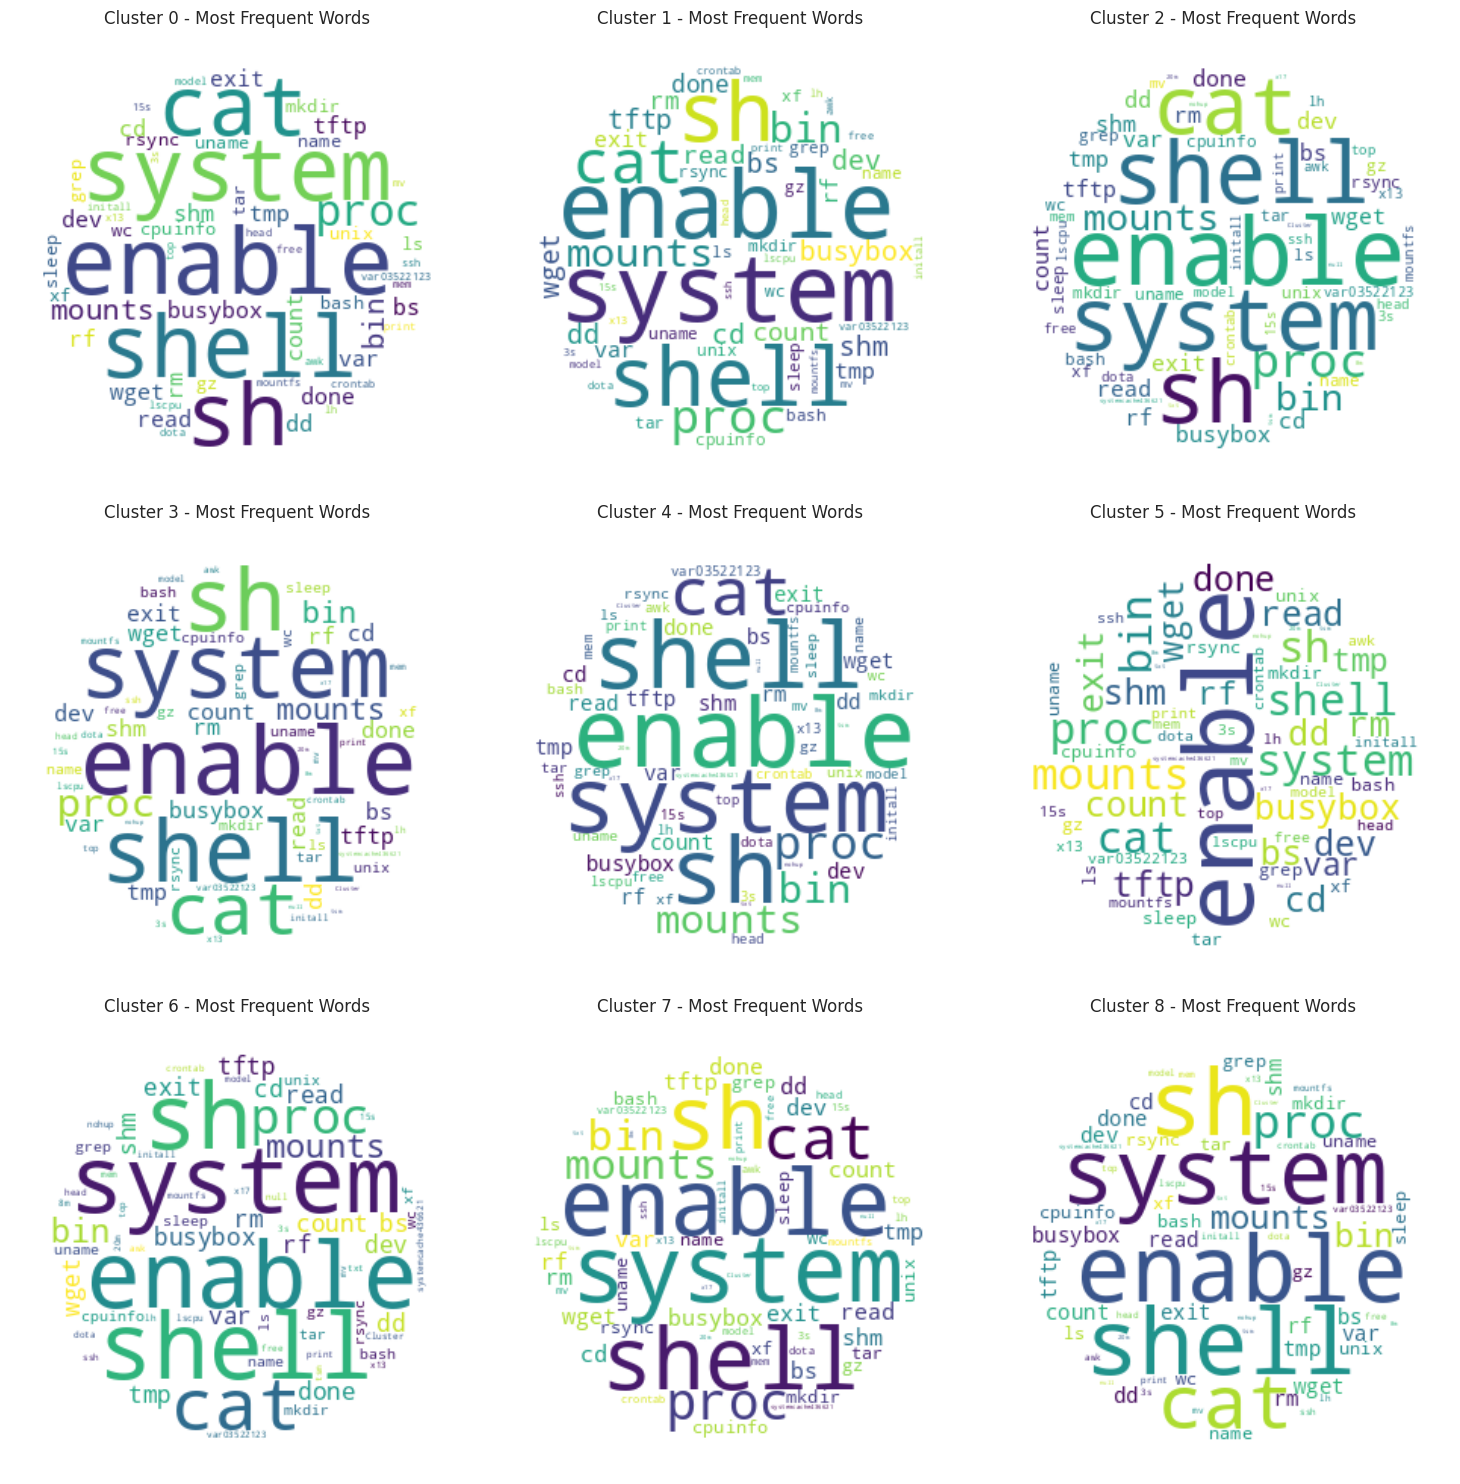

In [55]:
optimal_clusters = 9  # Optimal number of clusters

# Fit KMeans with the optimal number of clusters
kmeans_final = KMeans(n_clusters = optimal_clusters, random_state=42, n_init = 'auto')
cl_labels_final = kmeans_final.fit_predict(pca_result_tfidf)

# Add cluster labels to the DataFrame
result_df_exploded['Cluster'] = cl_labels_final

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
for cluster in range(optimal_clusters):
    cluster_data = result_df_exploded[result_df_exploded['Cluster'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # plt.figure(figsize=(6, 4))
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

##### Most Frequent Words for the GMM Cluster Algorithm

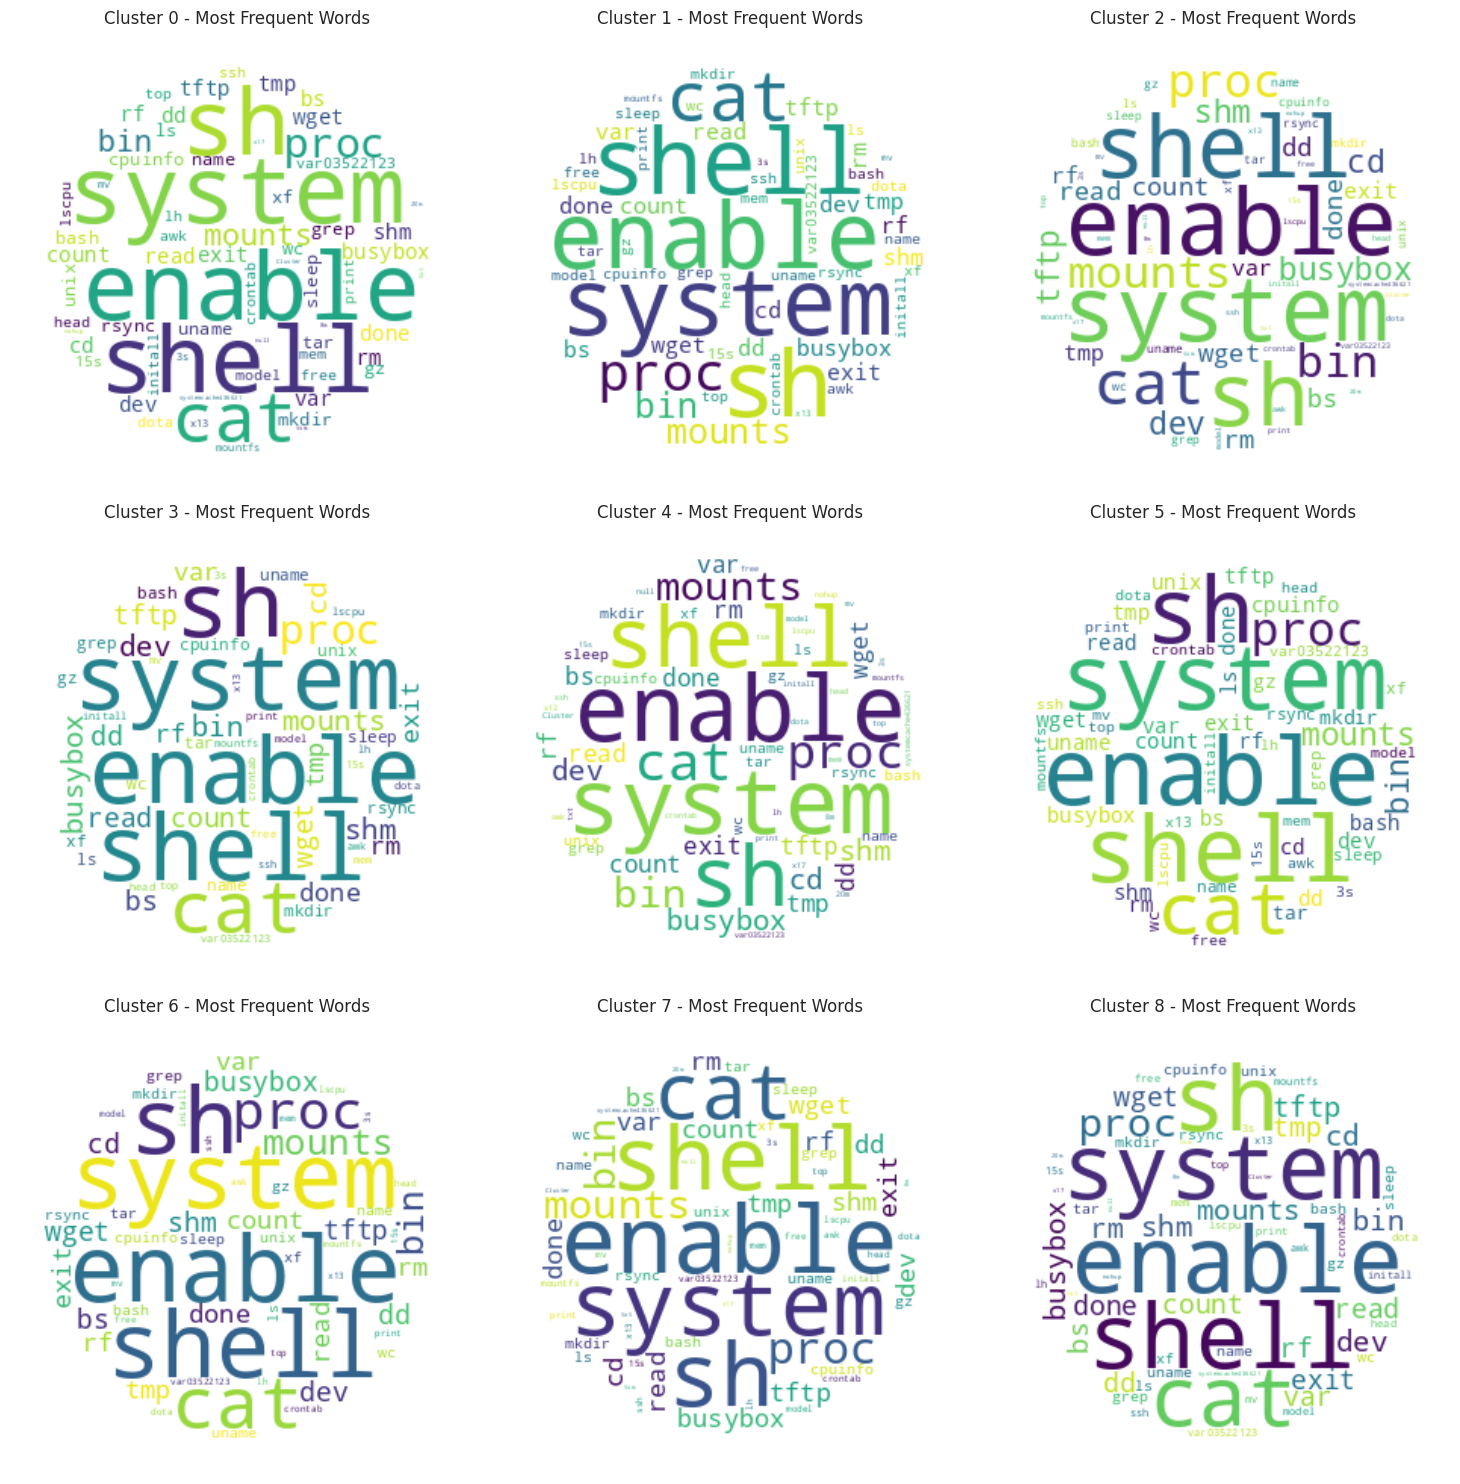

In [56]:
optimal_clusters = 9  # Optimal number of clusters

# Fit KMeans with the optimal number of clusters
gmm_final = GaussianMixture(n_components = optimal_clusters, covariance_type='full', random_state=42)
labels_gmm_final = gmm_final.fit_predict(pca_result_tfidf)
    
# Add cluster labels to the DataFrame
result_df_exploded['Cluster'] = labels_gmm_final

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for cluster in range(optimal_clusters):
    cluster_data = result_df_exploded[result_df_exploded['Cluster'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # axes settings 
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**3.5. Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

##### Intents Division into the K-Means Clusters

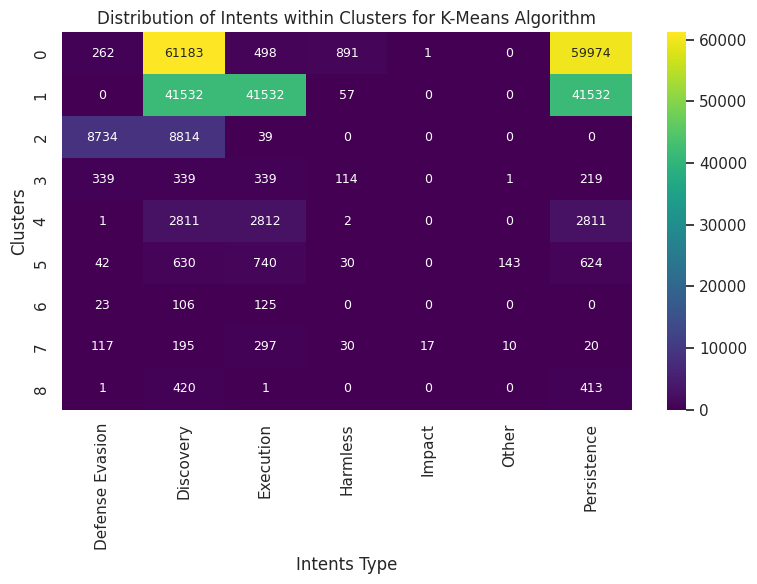

In [57]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_df = pd.DataFrame({'Set_Fingerprint': labels, 'Cluster': cl_labels_final})
cluster_counts = cluster_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for K-Means Algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

##### Intents Division into the GMM Clusters

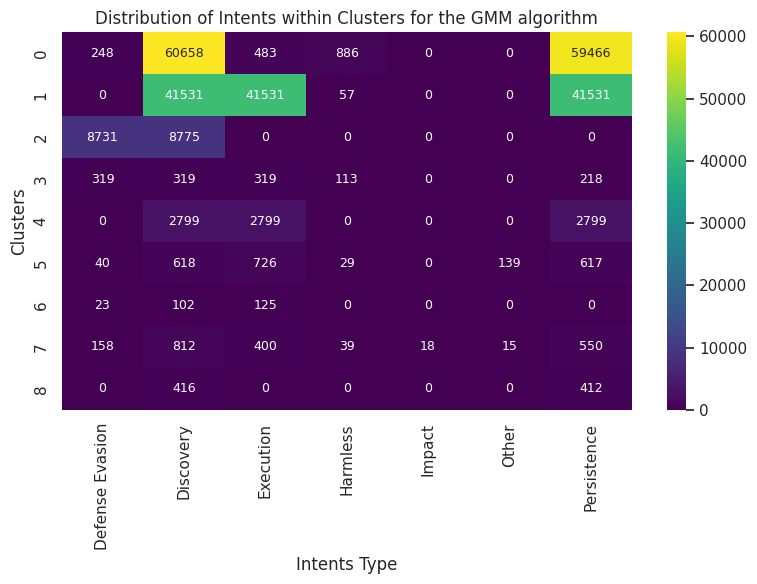

In [58]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_gmm_df = pd.DataFrame({'Set_Fingerprint': labels, 'Cluster': labels_gmm_final})
cluster_counts_gmm = cluster_gmm_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts_gmm

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts_gmm, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for the GMM algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

**3.6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics). As an example, see the image below, where we perform a similar exercise (through graph community detections). NOTE: you do not have to do this exercise for all the clusters, but only on some examples.**